# Building Angular Power Spectrum for two arbitrary kernels

---

The relevant equations are:

\begin{equation}
C^{XY}_\ell=\frac{1}{2}\int{\rm d}\chi\chi^{-2}K_X(\chi)K_{Y}(\chi)P_{q_\perp}\left(k=\frac{\ell}{\chi},z(\chi)\right),
\end{equation}

where 
\begin{align}
    K_{\kappa_{\bf B}}(\chi) &= \frac{3}{2}H_0^2\Omega_ma^{-1}\int_0^{\chi}{\rm d}\chi'\frac{\chi'(\chi-\chi')}{\chi}\frac{{\rm d}\chi'}{{\rm d}z}p\left(z(\chi')\right),\\
    K_b(\chi) &= \frac{\sigma_{\rm T}\bar{n}_{e,0}}{c}a(\chi)^{-2}e^{-\tau},
\end{align}
are the kernels for the gravitomagnetic lensing convergence and kSZ effect, respectively.

Notice that the $C_\ell$ calculation is further simplified due to the simple choice of $p(z(\chi'))=\delta^{{\rm D}}(\chi'-\chi_s)$. Hence the lensing kernel becomes
\begin{align}
 K_{\kappa_{\bf B}}(\chi) &= \frac{3}{2}H_0^2\Omega_ma^{-1}\int_0^{\chi}{\rm d}\chi'\frac{\chi'(\chi-\chi')}{\chi}\frac{{\rm d}\chi'}{{\rm d}z}p\left(z(\chi')\right),\\
                          &= \frac{3}{2}H_0^2\Omega_ma^{-1}\frac{\chi_s(\chi-\chi_s)}{\chi}H^{-1}(\chi_s)
\end{align}

---

\begin{equation}
    C_{ij}^{XY}(\ell) = c\int_{z_\text{min}}^{z_\text{max}}dz\frac{W_i^X(z)W_j^Y(z)}{H(z)r^2(z)}P_{\delta\delta}(k_\ell,z)
\end{equation}

In [1]:
# Import some libraries
import numpy as np

from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
import scienceplots

from classy import Class
from time import time
import vp_utils as utils
from astropy import constants as const
from astropy import units as u

plt.style.use(['science', 'no-latex'])
plt.rcParams.update({
    # Figure
    'figure.figsize': (6.8, 4.2),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,

    # Lines and markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Font
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,

    # Axes
    'axes.linewidth': 1.0,
    'axes.grid': False,
    'grid.alpha': 0.3,

    # Ticks
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,

    # Legend
    'legend.frameon': False,

    # Text rendering (LaTeX)
    'text.usetex': False,               # Optional: needs LaTeX installed
    'text.latex.preamble': r'\usepackage{amsmath,amssymb}',  # Optional
})

In [2]:
parameters_sim = utils.parameters_sim

In [3]:
CLASS = {}

# --- Cosmology parameters ---
params_base = {
    'output': 'tCl,sCl,lCl,mPk',
    'h': parameters_sim['h'],
    'Omega_cdm': parameters_sim['Omega_m'] - parameters_sim['Omega_b'],
    'Omega_b': parameters_sim['Omega_b'],
    'A_s': 2.1e-9,
    'n_s': 0.965,
    'tau_reio': 0.06,
    'modes': 's',
    'lensing': 'yes',
    'l_switch_limber': 50,
    'z_max_pk': 1080,
    'non_linear':'halofit',
    'P_k_max_1/Mpc' : '10',
    'l_max_scalars': 10000,
    # 'selection': 'dirac',
    # 'selection_mean': '3.0',
}

# Constant z
params_const = params_base.copy()
params_const.update({'z_pk': '3.0'})

CLASS['const_z'] = Class()
CLASS['const_z'].set(params_const)
CLASS['const_z'].compute()

# Variable z
z_list = np.geomspace(0.01, 1080, 50)
params_var = params_base.copy()
params_var.update({'z_pk': ','.join([str(z) for z in z_list])})

CLASS['var_z'] = Class()
CLASS['var_z'].set(params_var)
CLASS['var_z'].compute()

# --- Define k grid (in 1/Mpc) ---
kk = np.geomspace(1e-4, 10., num=1000)

# --- Get P(k,z) at fixed z=3 ---
Pk_m_class_const_z = CLASS['const_z'].get_pk_all(kk, 3., nonlinear=True)

# --- Get P(k,z) at several z ---


Pk_m_class_varz = np.array([ CLASS['var_z'].get_pk_all(kk, z, nonlinear=True) for z in z_list])

Pk_m_class_varz_4interp = Pk_m_class_varz.T   # shape = (len(k_vals), len(z_list))

# --- Get lensing Cl from CLASS ---
# cl = CLASS['var_z'].lensed_cl()
cl_tot = CLASS['var_z'].raw_cl(10000)   # unlensed spectrum
cl_lensed = CLASS['var_z'].lensed_cl(10000)  # lensed spectrum

ells = cl_tot['ell']
Cl_pp_tot = cl_tot['pp']  # lensing potential power spectrum
Cl_kk_tot = .25 * (ells+2)*(ells+1)*ells*(ells-1) * Cl_pp_tot  # convergence spectrum

ells_lensed = cl_lensed['ell']
Cl_pp_lensed = cl_lensed['pp']  # lensing potential power spectrum
Cl_kk_lensed = .25 * (ells+2)*(ells+1)*ells*(ells-1) * Cl_pp_lensed  # convergence spectrum

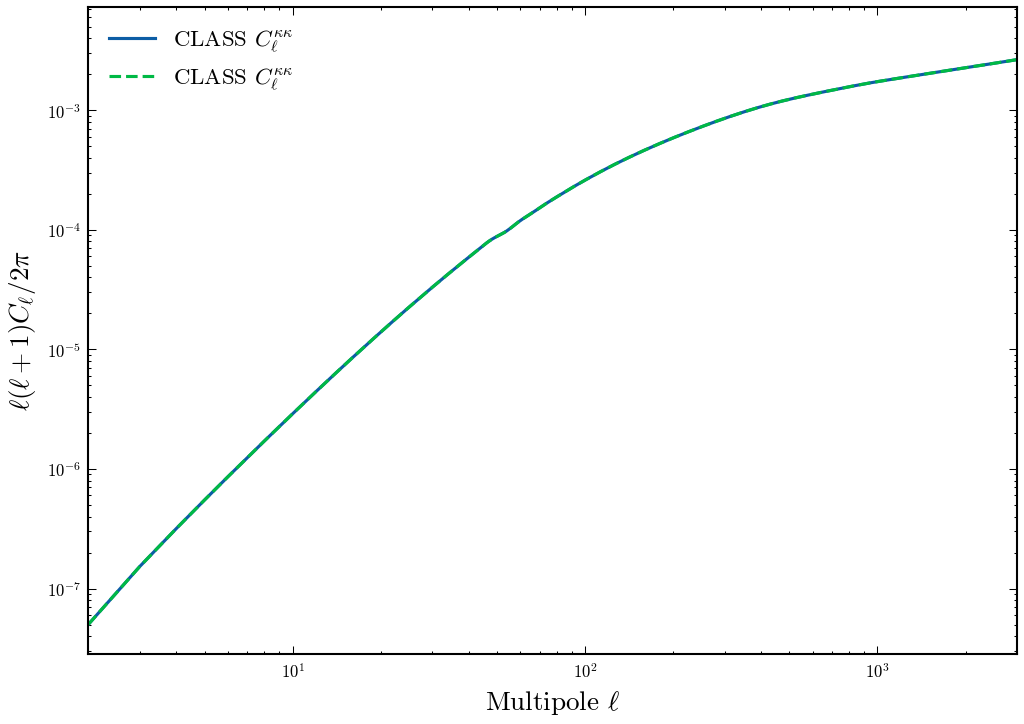

In [4]:
fig, ax = plt.subplots(figsize=(7, 5))

factor = ells*(ells+1)/2/np.pi

ax.loglog(ells[2:], factor[2:]*Cl_kk_tot[2:], label=r"CLASS $C_\ell^{\kappa\kappa}$")
ax.loglog(ells[2:], factor[2:]*Cl_kk_lensed[2:], '--',label=r"CLASS $C_\ell^{\kappa\kappa}$")


ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell/2\pi$", fontsize=13)

ax.legend(fontsize=11, loc="best", frameon=False)
plt.xlim([2,3000])
plt.tight_layout()
plt.show()


In [5]:
### Interpolating power spectra:

from scipy.interpolate import RegularGridInterpolator, interp1d

Pk_m_class_constz_interp = interp1d(np.log(kk), np.log(Pk_m_class_const_z), kind='cubic')

def Pk_m_class_constz_int(k):
    return np.exp(Pk_m_class_constz_interp(np.log(k)))


# Build interpolator: axes are (z, k)
Pk_m_class_varz_interp = RegularGridInterpolator(
    (np.log(kk), z_list),   # grid coordinates
    np.log(Pk_m_class_varz_4interp), # array with shape (len(z_list), len(k_vals))
    method='cubic',    # or "cubic" if you prefer smoother
    bounds_error=False,
    fill_value=None
)


def Pk_m_class_varz_int(x):
    k, z = x
    return np.exp(Pk_m_class_varz_interp((np.log(k), z)))

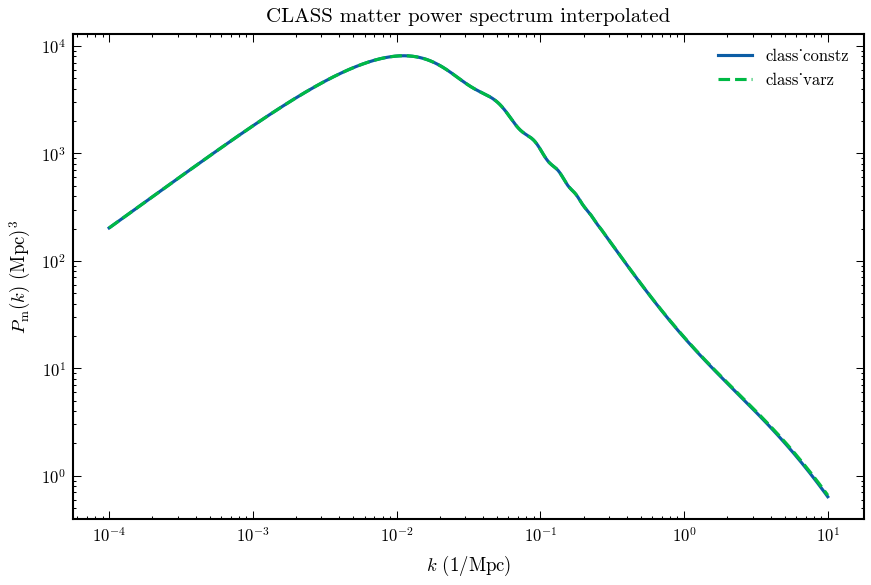

In [6]:
fig, ax = plt.subplots()

h_constz = CLASS['const_z'].h()
h_varz = CLASS['var_z'].h()

ax.loglog(kk, Pk_m_class_constz_int(kk), label='class_constz')
ax.loglog(kk, Pk_m_class_varz_int((kk,3)), '--', label='class_varz')

ax.set_ylabel(r'$P_\text{m}(k)$ (Mpc)$^{3}$')
ax.set_xlabel(r'$k$ (1/Mpc)')
ax.set_title('CLASS matter power spectrum interpolated')
ax.legend()

## Computing $C_\ell$ for the cross correlation

## Computation

In [15]:
ell_grid = np.arange(int(1e2), int(1e4))

C_ells_XY = {}

C_ells_XY['PhiPhi'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['kSZ'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['BB'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['B_X_kSZ'] = np.zeros_like(ell_grid, dtype=float)

for idx, ell in enumerate(ell_grid):


    C_ells_XY['PhiPhi'][idx] = utils.C_ell_PhiPhi(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_m_class_varz_int,
        Pk_evol=True,
    )

    C_ells_XY['kSZ'][idx] = utils.C_ell_kSZ(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_m_class_varz_int,
        Pk_evol=True,
    )

    C_ells_XY['BB'][idx] = utils.C_ell_BB(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_m_class_varz_int,
        Pk_evol=True,
    )

    C_ells_XY['B_X_kSZ'][idx] = utils.C_ell_B_X_kSZ(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=kk[0],
        kmax=kk[-1],
        Pk=Pk_m_class_varz_int,
        Pk_evol=True,
    )


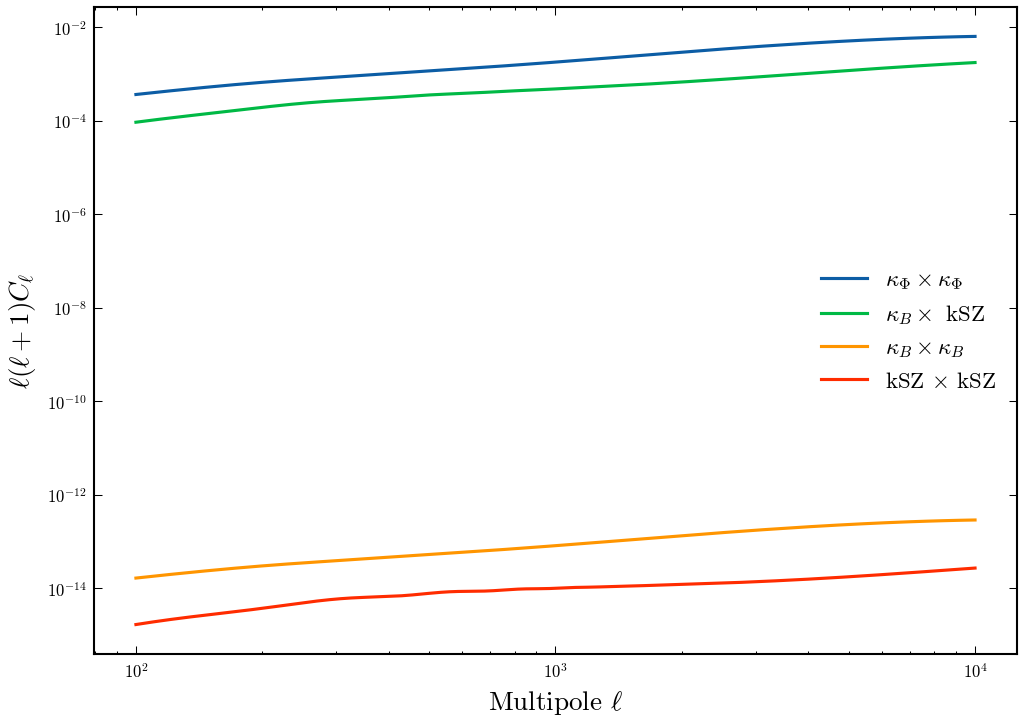

In [17]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['PhiPhi']      , label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['B_X_kSZ']     , label=r"$\kappa_B \times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['BB']          , label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['kSZ']         , label=r"kSZ $\times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
# ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()


### Testing integration methods

In [8]:
methods = ['cumsum', 'quad', 'simpson', 'trapezoid', 'cum_simpson', 'cum_trapezoid']
ell_grid = np.arange(int(1e2), int(1e4))

C_ell_3 = {}
for method in methods:
    start = time()
    C_ell_3[method] = np.zeros_like(ell_grid, dtype=float)
    for idx, ell in enumerate(ell_grid):
        C_ell_3[method][idx] = utils.C_ell_lensing(
                                z_s=3,
                                ell=ell,
                                z_min=1e-5,
                                kmin=kk[0],
                                kmax=kk[-1],
                                Pk=Pk_m_class_varz_int,
                                Pk_evol=True,
                                integr_method=method
                            )
    end = time()
    print(f"Method: {method}, time = {end-start:.3f} s")

AttributeError: module 'vp_utils' has no attribute 'C_ell_lensing'

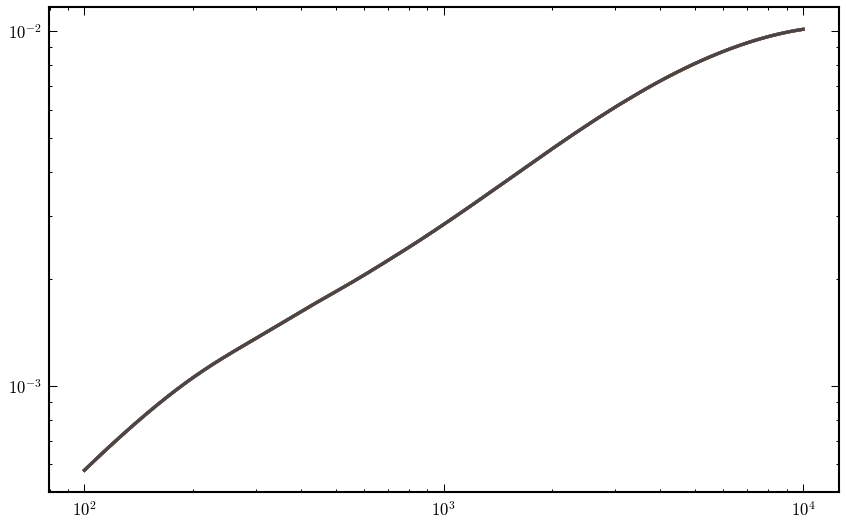

In [ ]:
fig, ax = plt.subplots()

for method in methods:
    ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ell_3[method]/2*np.pi, label=method)

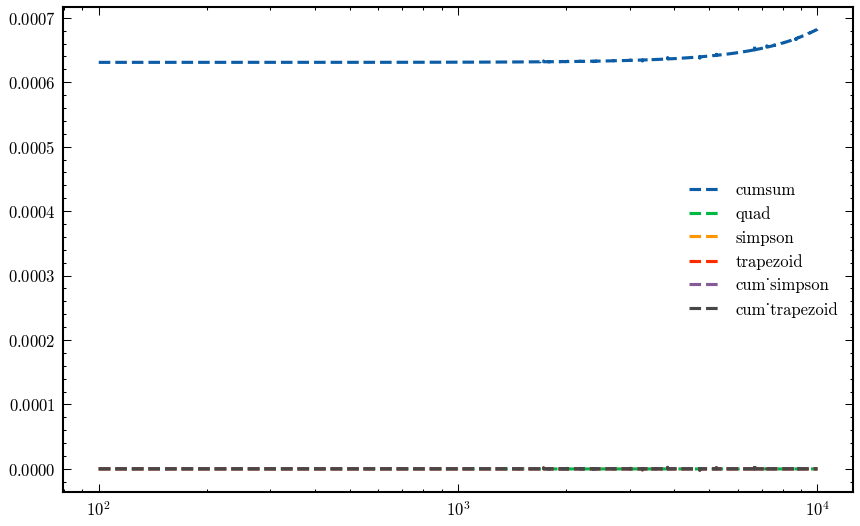

In [ ]:
methods = ['cumsum', 'quad', 'simpson', 'trapezoid', 'cum_simpson', 'cum_trapezoid']
idx = 5
fig, ax = plt.subplots()

for method in methods:
    ax.semilogx(ell_grid, C_ell_3[method]/C_ell_3['quad']-1, '--', label=method)

ax.legend()

### Comparing with CLASSs CMB lensing 

In [ ]:
methods = ['cumsum', 'quad', 'simpson', 'trapezoid', 'cum_simpson', 'cum_trapezoid']

ell_grid = np.arange(int(1e2), int(1e4))
C_ell_cmb = {}

for method in methods:
    start = time()
    C_ell_cmb[method] = np.zeros_like(ell_grid, dtype=float)
    for idx, ell in enumerate(ell_grid):
        C_ell_cmb[method][idx] = utils.C_ell_lensing(
                                z_s=CLASS['var_z'].get_current_derived_parameters(['z_rec'])['z_rec'],
                                ell=ell,
                                z_min=1e-5,
                                kmin=kk[0],
                                kmax=kk[-1],
                                Pk=Pk_m_class_varz_int,
                                Pk_evol=True,
                                integr_method=method
                            )
    end = time()
    print(f"Method: {method}, time = {end-start:.3f} s")

Method: cumsum, time = 30.851 s
Method: quad, time = 472.449 s
Method: simpson, time = 30.528 s
Method: trapezoid, time = 29.986 s
Method: cum_simpson, time = 31.243 s
Method: cum_trapezoid, time = 30.571 s


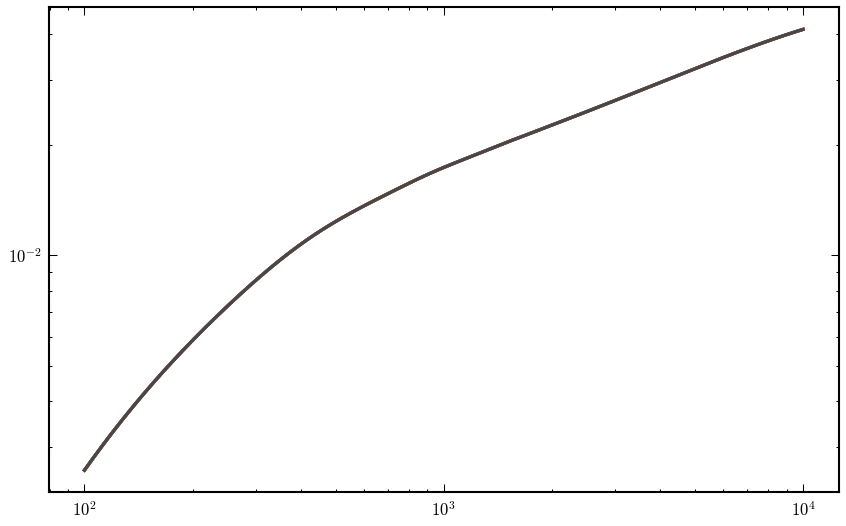

In [ ]:
fig, ax = plt.subplots()

for method in methods:
    ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ell_cmb[method]/2*np.pi, label=method)

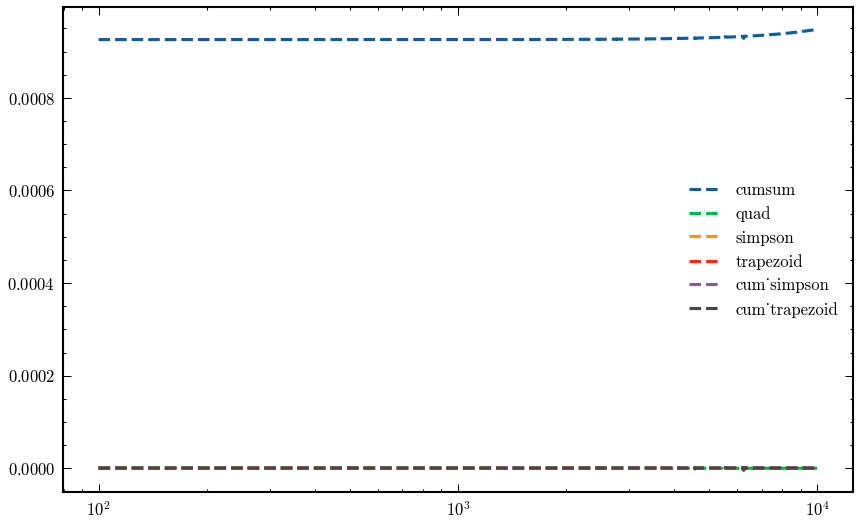

In [ ]:
methods = ['cumsum', 'quad', 'simpson', 'trapezoid', 'cum_simpson', 'cum_trapezoid']
idx = 5
fig, ax = plt.subplots()

for method in methods:
    ax.semilogx(ell_grid, C_ell_cmb[method]/C_ell_cmb['quad']-1, '--', label=method)

ax.legend()

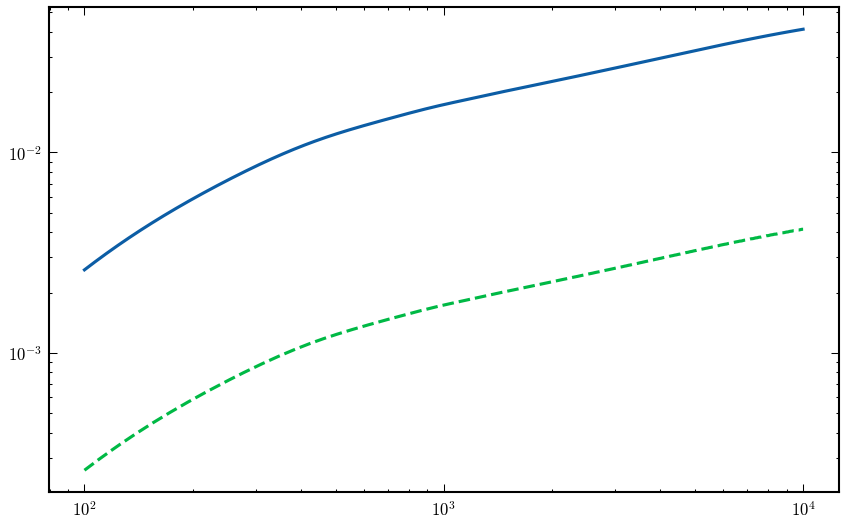

In [ ]:
fig, ax = plt.subplots()

ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ell_cmb['quad']/2*np.pi, label=method)
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*Cl_kk_tot[ell_grid]/2/np.pi, '--', label='CLASS')

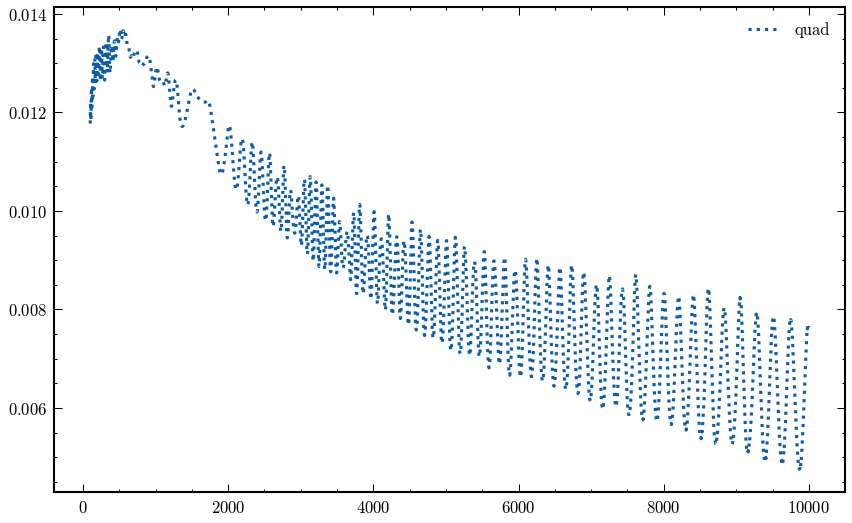

In [ ]:
i=1


fig, ax = plt.subplots()

ax.plot(ell_grid, C_ell_cmb[methods[i]]/Cl_kk_tot[ell_grid]-1, ':', label=methods[i])

ax.legend()

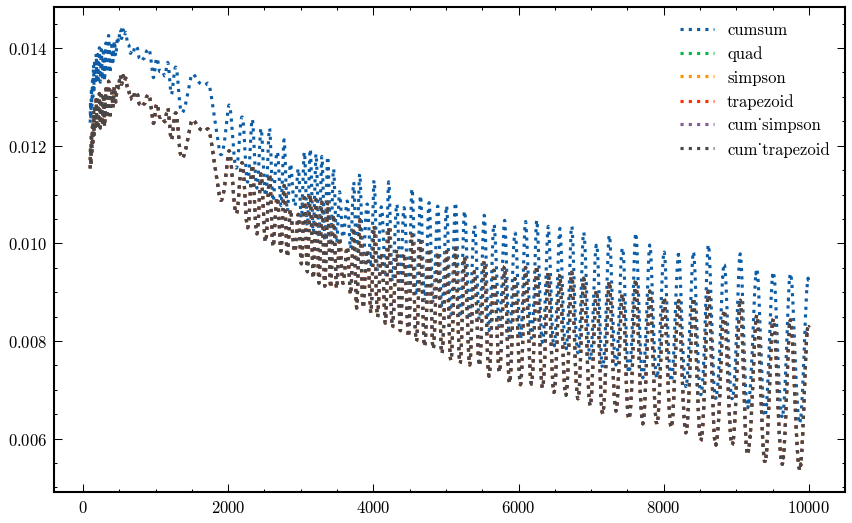

In [ ]:
fig, ax = plt.subplots()

for method in methods:
    ax.plot(ell_grid, C_ell_cmb[method]/Cl_kk_tot[ell_grid]-1, ':', label=method)


ax.legend()

In [ ]:
ell_grid

array([ 100,  101,  102, ..., 9997, 9998, 9999])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

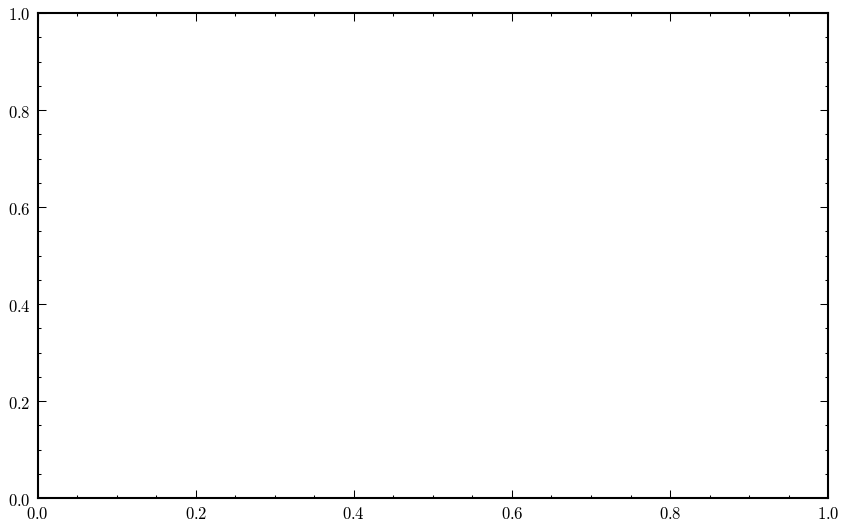

In [ ]:
fig, ax = plt.subplots()

for method in methods:
    ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ell[method]/2*np.pi, label=method)

In [ ]:
methods = ['simpson', 'quad', 'cumsum']

ell_grid = np.arange(int(1e2), int(1e4))
z_grid = np.linspace(1, 1080, 15)

C_ells_lensing = {}

for z in z_grid:
    C_ells_lensing[z] = np.zeros_like(ell_grid, dtype=float)
    for idx, ell in enumerate(ell_grid):
        C_ells_lensing[z][idx] =utils.C_ell_lensing(
            z_s=z,
            ell=ell,
            z_min=1e-5,
            kmin=kk[0],
            kmax=kk[-1],
            Pk=Pk_m_class_varz_int,
            Pk_evol=True,
            integr_method=method
        )

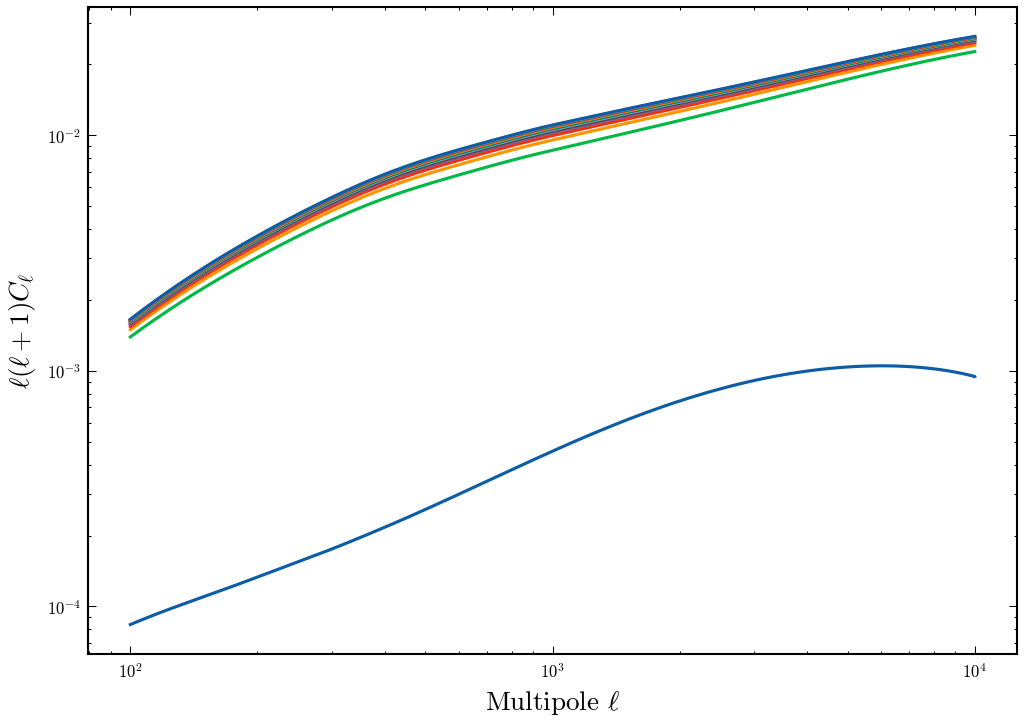

In [ ]:
ell_grid = np.arange(int(1e2), int(1e4))

fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
for z in z_grid:
    ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_lensing[z], label=rf"z={z:.1f}")
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
# ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
# ax.set_ylim(1e-11, 1e-1)
# ax.set_xlim(1e2, 1e4)

plt.tight_layout()
plt.show()


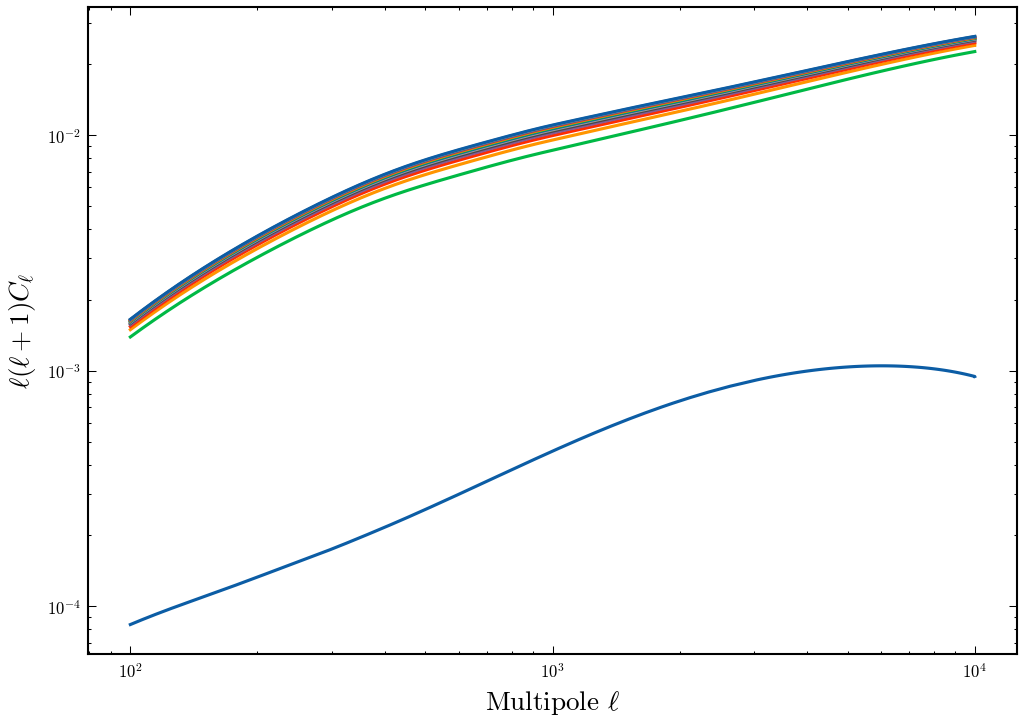

In [ ]:
ell_grid = np.arange(int(1e2), int(1e4))

fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
for z in z_grid:
    ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_lensing[z], label=rf"z={z:.1f}")
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
# ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
# ax.set_ylim(1e-11, 1e-1)
# ax.set_xlim(1e2, 1e4)

plt.tight_layout()
plt.show()


In [ ]:
ell_grid = np.arange(int(1e2), int(1e4))
cmb_lensing = np.zeros_like(ell_grid, dtype=float)

for idx, ell in enumerate(ell_grid):
    cmb_lensing[idx] = C_ell_lensing(
                z_s=1080,
                ell=ell,
                z_min=1e-5,
                kmin=kk[0],
                kmax=kk[-1],
                Pk=Pk_m_class_varz_int,
                Pk_evol=True,
            )

In [ ]:
ell_grid = np.arange(int(1e2), int(1e4))
z_grid = np.linspace(1, 500, 10)

C_ells_lensing = {}

for z in z_grid:
    C_ells_lensing[z] = np.zeros_like(ell_grid, dtype=float)

    for idx, ell in enumerate(ell_grid):
        C_ells_lensing[z][idx] = utils.C_ell_lensing(
            z_s=z,
            ell=ell,
            z_min=1e-5,
            kmin=kk[0],
            kmax=kk[-1],
            Pk=Pk_m_class_varz_int,
            Pk_evol=True,
        )

ValueError: setting an array element with a sequence.

In [ ]:
zz = np.linspace(1e-5, 1080, 10000)

chii = utils.chi_of_z(zz)
chi_s = utils.chi_of_z(1080)

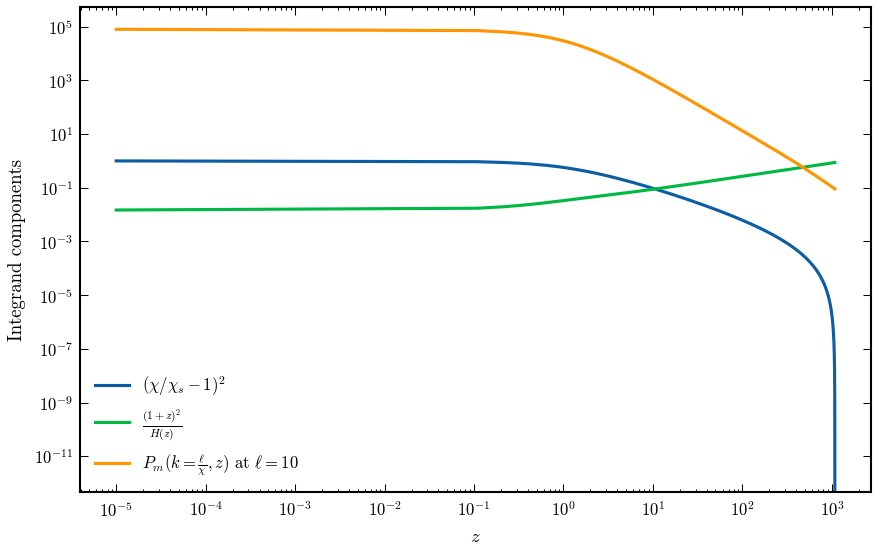

In [ ]:
fig, ax = plt.subplots()

ax.loglog(zz, (chii/chi_s-1)**2, label=r'$(\chi/\chi_s-1)^2$')
ax.loglog(zz, (1+zz)**2/utils.Hubble(zz, parameters_sim), label=r'$\frac{(1+z)^2}{H(z)}$')
ax.loglog(zz, Pk_m_class_varz_int((1e-2, zz)), label=r'$P_m(k=\frac{\ell}{\chi},z)$ at $\ell=10$')


ax.set_xlabel(r'$z$')
ax.set_ylabel(r'Integrand components')
ax.legend()


In [ ]:
Pk_m_class_varz_int((1e-2, zz)).max()

4.212852966963913e+84

In [ ]:
zz = [0.1, 0.5, 1., 2., 3., 10., 100., 1080.]

fig, ax = plt.subplots()

for z in zz: 
    ax.loglog(kk, Pk_m_class_varz_int((kk,z)), label=rf'z={z:.1f}')


ax.legend()